In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 14 - Multinomial processing trees

## 14.1 Multinomial processing model of pair-clustering
Multinomial processing trees (MPTs: Batchelder & Riefer, 1980, 1986; Chechile, 1973; Chechile & Meyer, 1976) provide one approach to modeling the finding that semantically related items are often recalled consecutively. An MPT model assumes that observed behavior arises from a sequence of cognitive events, able to be represented by a rooted tree architecture

$$ c,r,u \sim \text{Beta}(1,1)  $$
$$ \theta_{1} = cr $$
$$ \theta_{2} = (1\,-\,c)u^2 $$
$$ \theta_{3} = 2u\,(1\,-\,c)\,(1\,-\,u) $$
$$ \theta_{4} = c\,(1\,-\,r)\,+\,(1\,-\,c)\,(1\,-\,u)^2 $$
$$ \mathbf k \sim \text{Multinomial}(\mathbf \theta,n)$$

In [2]:
indiv_trial = {}
Nt = 3
kall = np.array([[45, 24, 97, 254],
                 [106, 41, 107, 166],
                 [243, 64, 65, 48]])
for trial in np.arange(Nt):
    k = kall[trial, :]
    n = sum(k)
    with pm.Model() as model1:
        c = pm.Beta('c', alpha=1, beta=1)
        r = pm.Beta('r', alpha=1, beta=1)
        u = pm.Beta('u', alpha=1, beta=1)
        
        t1 = c*r
        t2 = (1-c)*(u**2)
        t3 = 2*u*(1-c)*(1-u)
        t4 = c*(1-r)+(1-c)*(1-u)**2
        
        kobs = pm.Multinomial("kobs", p=[t1, t2, t3, t4], n=n, observed=k)
        trace = pm.sample(3e3, njobs=2, progressbar=False)
    
    # keep trace for later analysis
    indiv_trial[trial] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 8700
Interrupted at 8,700 [4%]: Average Loss = 35.12
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 9500
Interrupted at 9,500 [4%]: Average Loss = 26.577
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 8300
Interrupted at 8,300 [4%]: Average Loss = 58.46


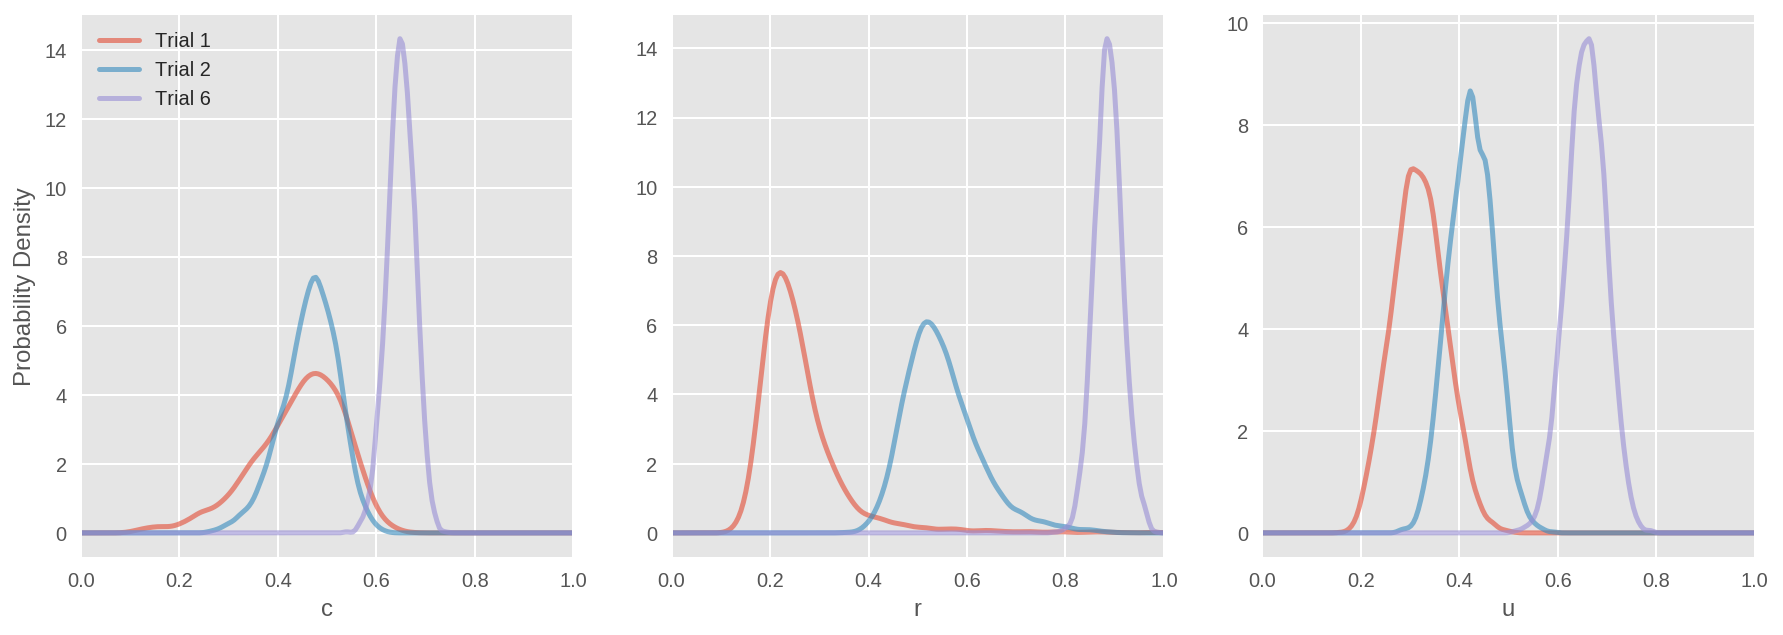

In [3]:
from scipy.stats.kde import gaussian_kde

fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 3)
x1=np.linspace(0, 1, 200)
plotparm=['c', 'r', 'u']
trialname=['Trial 1', 'Trial 2', 'Trial 6']
ax0 = {}
for trial in np.arange(Nt):
    for ip, ii in enumerate(plotparm):
        cpost = indiv_trial[trial][ii][50:]
        ax0[ip] = plt.subplot(gs[ip])
        my_pdf = gaussian_kde(cpost)
        ax0[ip].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6) # distribution function
        plt.xlim([0, 1])
        plt.xlabel(ii)
    
ax0 = plt.subplot(gs[0])
plt.legend(trialname, loc='upper left')
plt.ylabel('Probability Density')
plt.show()

## 14.2 Latent-trait MPT model

$$ \hat \mu^c, \hat \mu^r, \hat \mu^u \sim \text{Gaussian}(0,1)$$
$$ \hat \xi^c, \hat \xi^r, \hat \xi^u \sim \text{Uniform}(0,100)$$
$$ \Sigma^{-1} \sim \text{Wishart}(I,4)$$
$$ (\hat \delta_{i}^c,\hat \delta_{i}^r,\hat \delta_{i}^u) \sim \text{MvGaussian}(0,\Sigma^{-1})$$
$$ c_{i} = \Phi(\hat \mu^c\,+\,\hat \xi^c\hat \delta_{i}^c)$$
$$ r_{i} = \Phi(\hat \mu^r\,+\,\hat \xi^r\hat \delta_{i}^r)$$
$$ u_{i} = \Phi(\hat \mu^u\,+\,\hat \xi^u\hat \delta_{i}^u)$$
$$ \theta_{i1} = c_i r_i $$
$$ \theta_{i2} = (1\,-\,c_i)u_i^2 $$
$$ \theta_{i3} = 2u_i\,(1\,-\,c_i)\,(1\,-\,u_i) $$
$$ \theta_{i4} = c_i\,(1\,-\,r_i)\,+\,(1\,-\,c_i)\,(1\,-\,u_i)^2 $$
$$ \mathbf k_i \sim \text{Multinomial}(\mathbf \theta_i,n)$$

In [5]:
### Riefer et al (2002) data:
Nsubj = 21
Nitem = 20
response_1=np.array([2,4,4,10,2,1,3,14,2,2,5,11,6,0,4,10,1,
                     0,4,15,1,0,2,17,1,2,4,13,4,1,6,9,5,1,4,
                     10,1,0,9,10,5,0,3,12,0,1,6,13,1,5,7,7,1,
                     1,4,14,2,2,3,13,2,1,5,12,2,0,6,12,1,0,5,
                     14,2,1,8,9,3,0,2,15,1,2,3,14]).reshape(21,-1)
response_2=np.array([7,5,3,5,5,2,3,10,6,2,7,5,9,4,2,5,2,2,7,
                     9,1,3,3,13,5,0,5,10,7,3,4,6,7,3,6,4,4,1,
                     10,5,9,1,2,8,3,1,6,10,3,5,9,3,2,0,6,12,
                     8,0,3,9,3,2,7,8,7,1,5,7,2,1,6,11,5,3,5,
                     7,5,0,6,9,6,2,2,10]).reshape(21,-1)
response_6=np.array([14,3,1,2,12,3,1,4,18,0,1,1,15,3,0,2,7,
                     1,10,2,3,6,11,0,8,4,3,5,17,1,1,1,13,4,
                     3,0,11,6,1,2,16,1,2,1,10,1,3,6,7,13,0,
                     0,8,4,3,5,16,1,1,2,5,4,7,4,15,0,5,0,6,
                     3,6,5,17,2,0,1,17,1,0,2,8,3,6,3]).reshape(21,-1)
kall={}
kall[0] = response_1
kall[1] = response_2
kall[2] = response_6

In [6]:
p = 3
nu= p+2
indiv_trial2 = {}
Nt = 3

def Phi(x):
    # probit transform 
    return (1.0 + tt.erf(x / np.sqrt(2.0))) / 2.0
        
for trial in np.arange(Nt):
    k = kall[trial]
    with pm.Model():
        mu = pm.Normal('mu', mu=0, sd=1, shape=p)
        xi = pm.Uniform('xi', lower=0, upper=100, shape=p)
        
        wishart = pm.WishartBartlett('wishart', S=np.eye(p), nu=nu)
        cov = tt.nlinalg.matrix_inverse(wishart)
        # We can specify separate priors for sigma and the correlation matrix:
#         sd_dist = pm.HalfCauchy.dist(beta=2.5)
#         packed_chol = pm.LKJCholeskyCov('chol_cov', p, 2, sd_dist)
#         # compute the covariance matrix
#         chol = pm.expand_packed_triangular(p, packed_chol, lower=True)
#         cov = tt.dot(chol, chol.T)
        
        delta = pm.MvNormal('delta', mu=np.zeros(Nt), cov=cov, shape=(Nsubj, p))
        
        c = Phi(mu[0]+xi[0]*tt.dot(delta, [1, 0, 0]))
        r = Phi(mu[1]+xi[1]*tt.dot(delta, [0, 1, 0]))
        u = Phi(mu[2]+xi[2]*tt.dot(delta, [0, 0, 1]))
        
        t1 = c*r
        t2 = (1-c)*(u**2)
        t3 = 2*u*(1-c)*(1-u)
        t4 = c*(1-r)+(1-c)*(1-u)**2
        
        muc = pm.Deterministic('muc', Phi(mu[0]))
        mur = pm.Deterministic('mur', Phi(mu[1]))
        muu = pm.Deterministic('muu', Phi(mu[2]))
        
#         p_ = tt.stack([t1, t2, t3, t4])
#         kobs = pm.Multinomial('kobs', p=p_, n=Nitem, observed=k.T)
        # Multinomial data likelihood
        kobs = [pm.Multinomial('kobs_%i'%i, p=[t1[i], t2[i], t3[i], t4[i]], n=Nitem, 
                                     observed=k[i]) for i in np.arange(Nsubj)]
        
        trace = pm.sample(5e4, init=None, step=pm.Metropolis())
    
    # keep trace for later analysis
    indiv_trial2[trial] = trace

Added new variable c to model diagonal of Wishart.
Added new variable z to model off-diagonals of Wishart.
100%|██████████| 50500/50500.0 [02:12<00:00, 382.26it/s]
Added new variable c to model diagonal of Wishart.
Added new variable z to model off-diagonals of Wishart.
100%|██████████| 50500/50500.0 [02:22<00:00, 354.32it/s]
Added new variable c to model diagonal of Wishart.
Added new variable z to model off-diagonals of Wishart.
100%|██████████| 50500/50500.0 [02:08<00:00, 392.44it/s]


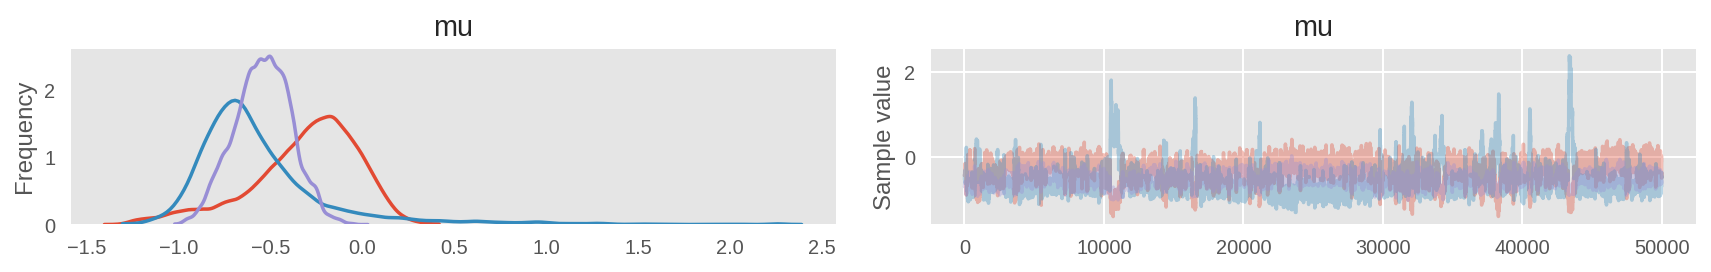

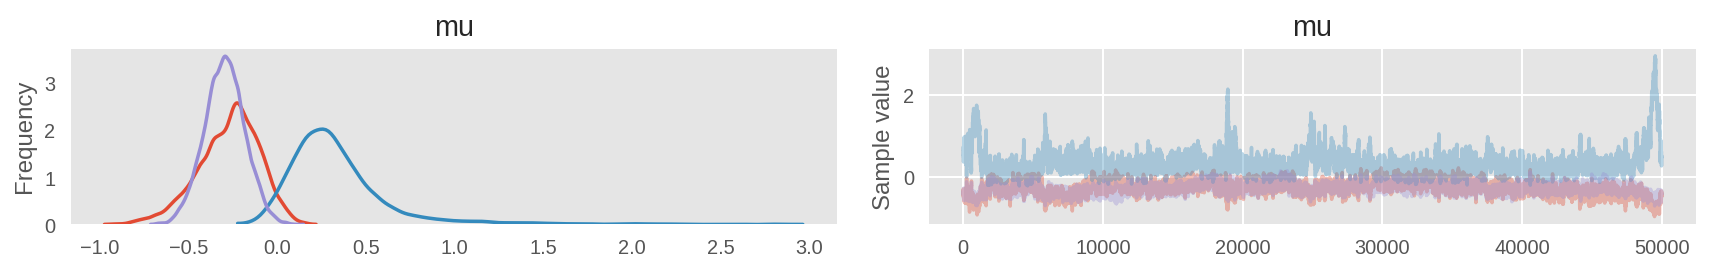

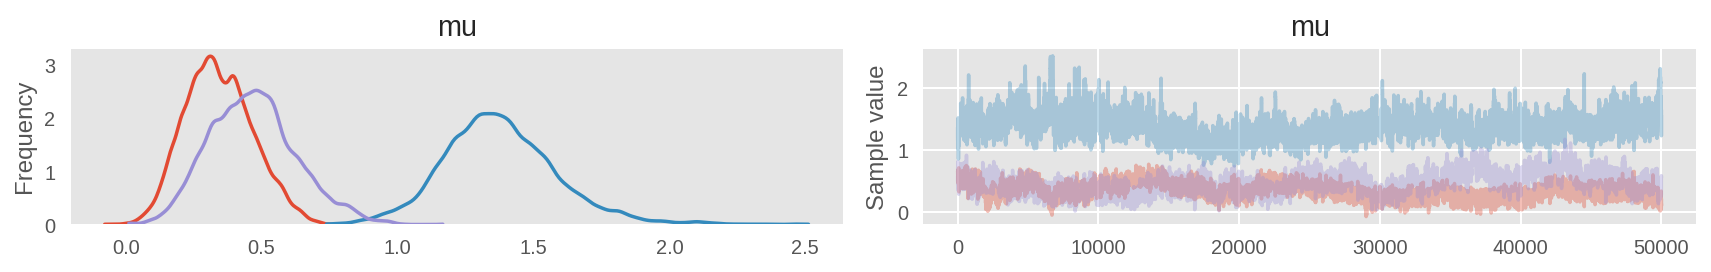

In [7]:
for trial in np.arange(Nt):
    pm.traceplot(indiv_trial2[trial], varnames=['mu']);

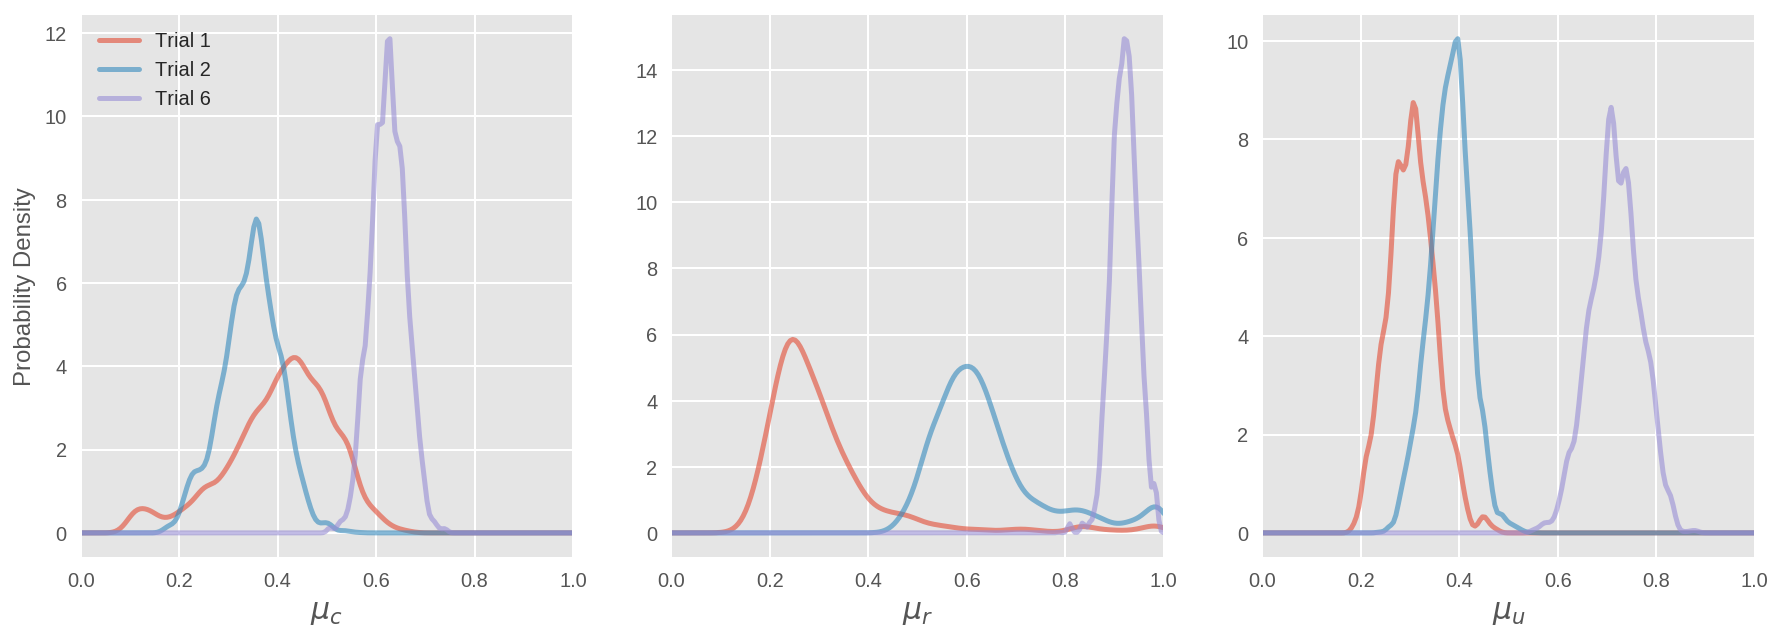

In [8]:
burnin=40000
import scipy.special as sp

fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 3)
x1=np.linspace(0, 1, 200)
plotparm=[r'$\mu_c$', r'$\mu_r$', r'$\mu_u$']
trialname=['Trial 1', 'Trial 2', 'Trial 6']
ax0 = {}

def npPhi(x):
    # probit transform 
    return (1.0 + sp.erf(x / np.sqrt(2.0))) / 2.0
        
for trial in np.arange(Nt):
    mupost=indiv_trial2[trial]['mu'][burnin:]
    for ip, ii in enumerate(plotparm):
        cpost = npPhi(mupost[:, ip])
        ax0[ip] = plt.subplot(gs[ip])
        my_pdf = gaussian_kde(cpost)
        ax0[ip].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6) # distribution function
        plt.xlim([0, 1])
        plt.xlabel(ii, fontsize=15)
    
ax0 = plt.subplot(gs[0])
plt.legend(trialname, loc='upper left')
plt.ylabel('Probability Density')
plt.show()

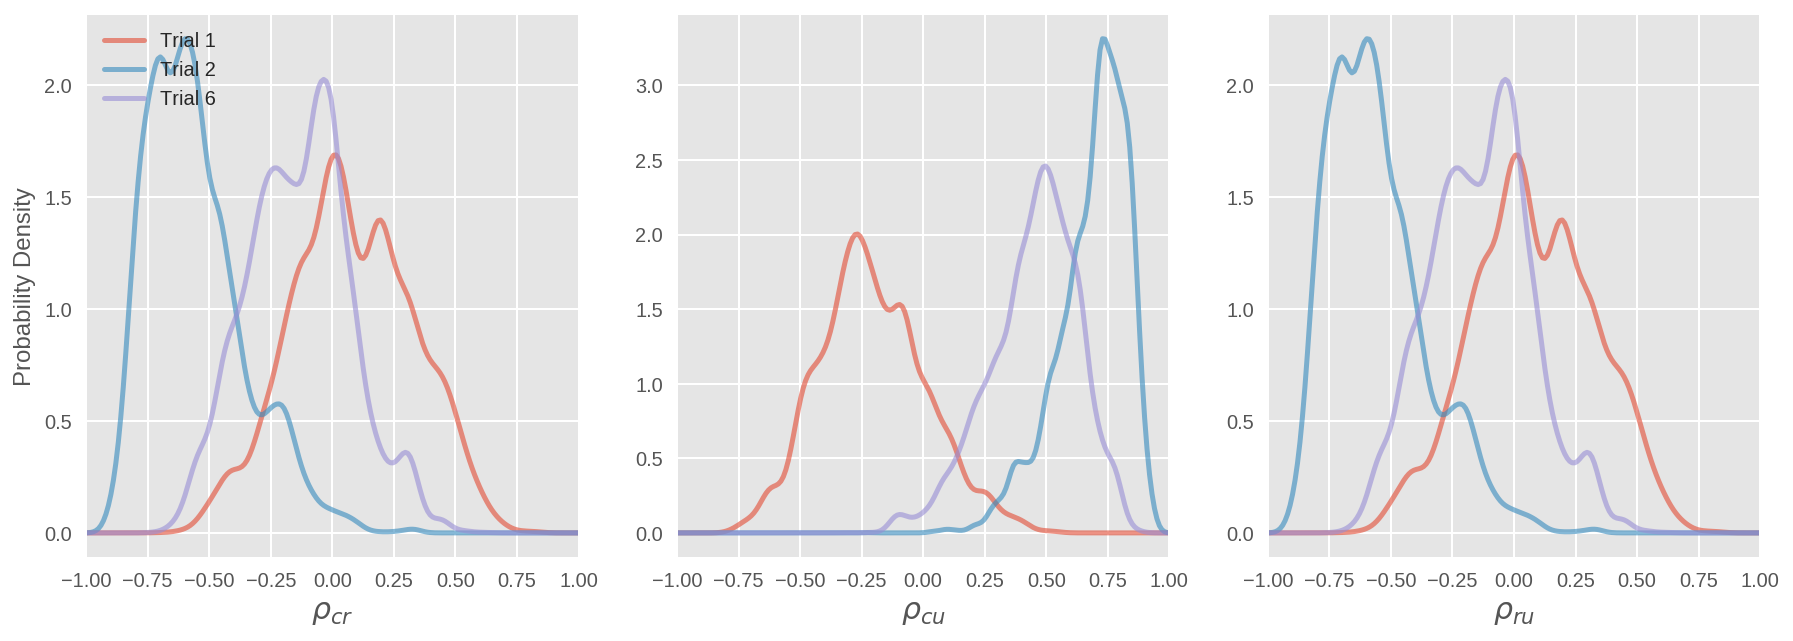

In [9]:
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 3)
x1=np.linspace(-1, 1, 200)
plotparm2=[r'$\rho_{cr}$', r'$\rho_{cu}$', r'$\rho_{ru}$']

for trial in np.arange(Nt):
    sigmainvpost=indiv_trial2[trial]['wishart'][burnin:]
    tmpn=sigmainvpost.shape[0]
    sigmapost=np.ndarray((tmpn, 3, 3), dtype=float)
    for i in range(tmpn):
        sigmapost[i, :, :]=np.linalg.inv(sigmainvpost[i, :, :])
        
    cpost0 = sigmapost[:, 0, 1]/np.sqrt(sigmapost[:, 0, 0]*sigmapost[:, 1, 1])
    ax0 = plt.subplot(gs[0])
    my_pdf = gaussian_kde(cpost0)
    ax0.plot(x1, my_pdf(x1), lw=2.5, alpha=0.6) # distribution function
    plt.xlim([-1, 1])
    plt.xlabel(plotparm2[0], fontsize=15)
    
    cpost1 = sigmapost[:, 0, 2]/np.sqrt(sigmapost[:, 0, 0]*sigmapost[:, 2, 2])
    ax1 = plt.subplot(gs[1])
    my_pdf = gaussian_kde(cpost1)
    ax1.plot(x1, my_pdf(x1), lw=2.5, alpha=0.6) # distribution function
    plt.xlim([-1, 1])
    plt.xlabel(plotparm2[1], fontsize=15)
    
    cpost2 = sigmapost[:, 1, 2]/np.sqrt(sigmapost[:, 1, 1]*sigmapost[:, 2, 2])
    ax2 = plt.subplot(gs[2])
    my_pdf = gaussian_kde(cpost0)
    ax2.plot(x1, my_pdf(x1), lw=2.5, alpha=0.6) # distribution function
    plt.xlim([-1, 1])
    plt.xlabel(plotparm2[2], fontsize=15)
    
ax0 = plt.subplot(gs[0])
plt.legend(trialname, loc='upper left')
plt.ylabel('Probability Density')
plt.show()

The above model works fine, but using Wishart is highly discouraged, including the Wishart-Bartlett form.Below we used a LKJ distribution (Cholesky decomposed version) as prior for covariance matrix.

In [23]:
Nd=3
with pm.Model() as modelk:
    mu = pm.Normal('mu', mu=0, sd=1, shape=Nd)
    xi = pm.Uniform('xi', lower=0, upper=100, shape=Nd)

    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', n=Nd, eta=1, sd_dist=sd_dist)
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(Nd, packed_chol, lower=True)

    delta = pm.MvNormal('delta', mu=np.zeros(Nt), chol=chol, shape=(Nsubj, Nd))

    c = Phi(mu[0]+xi[0]*tt.dot(delta, [1, 0, 0]))
    r = Phi(mu[1]+xi[1]*tt.dot(delta, [0, 1, 0]))
    u = Phi(mu[2]+xi[2]*tt.dot(delta, [0, 0, 1]))

    t1 = c*r
    t2 = (1-c)*(u**2)
    t3 = 2*u*(1-c)*(1-u)
    t4 = c*(1-r)+(1-c)*(1-u)**2

    muc = pm.Deterministic('muc', Phi(mu[0]))
    mur = pm.Deterministic('mur', Phi(mu[1]))
    muu = pm.Deterministic('muu', Phi(mu[2]))

    p_ =    tt.transpose(tt.stack([t1, t2, t3, t4]))
    kobs = pm.Multinomial('kobs', p=p_, n=Nitem, observed=k)
    trace = pm.sample(1e3, init=None)

Assigned NUTS to mu
Assigned NUTS to xi_interval__
Assigned NUTS to chol_cov_cholesky_cov_packed__
Assigned NUTS to delta
100%|██████████| 1500/1500.0 [11:00<00:00,  5.12it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 64 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



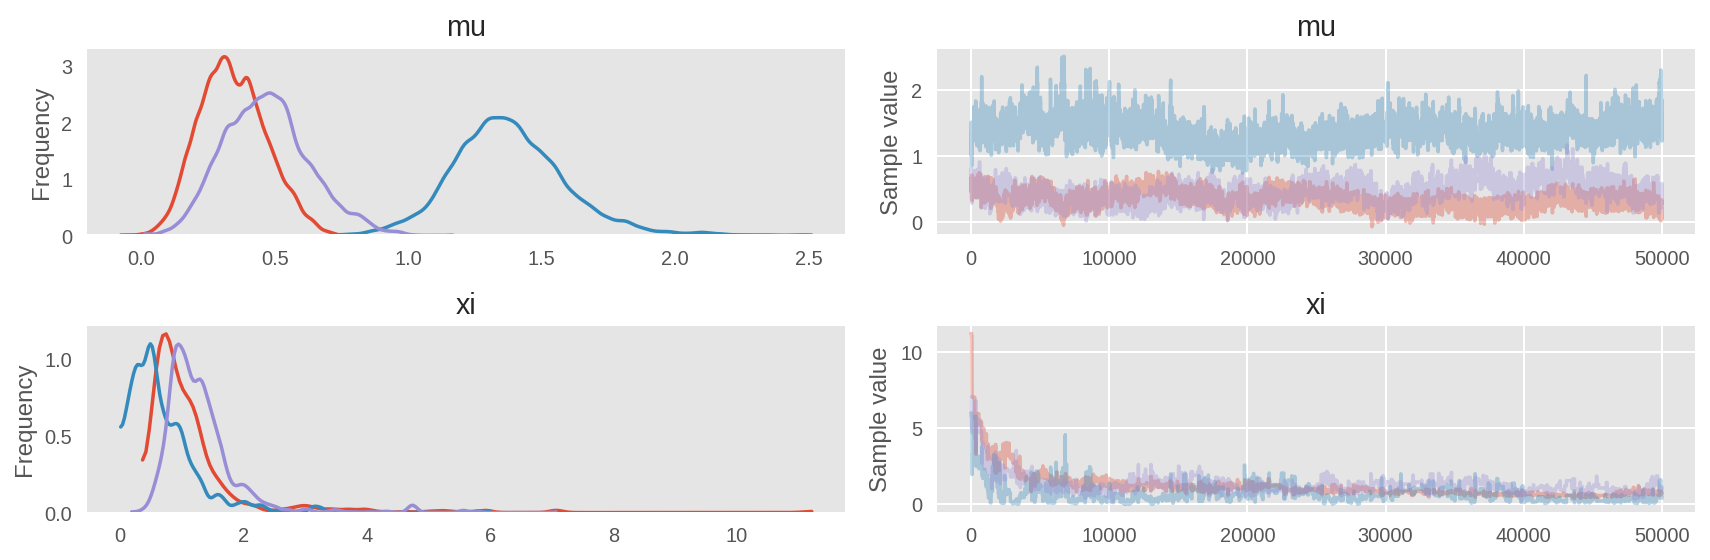

In [24]:
pm.traceplot(indiv_trial2[2], varnames=['mu', 'xi']);

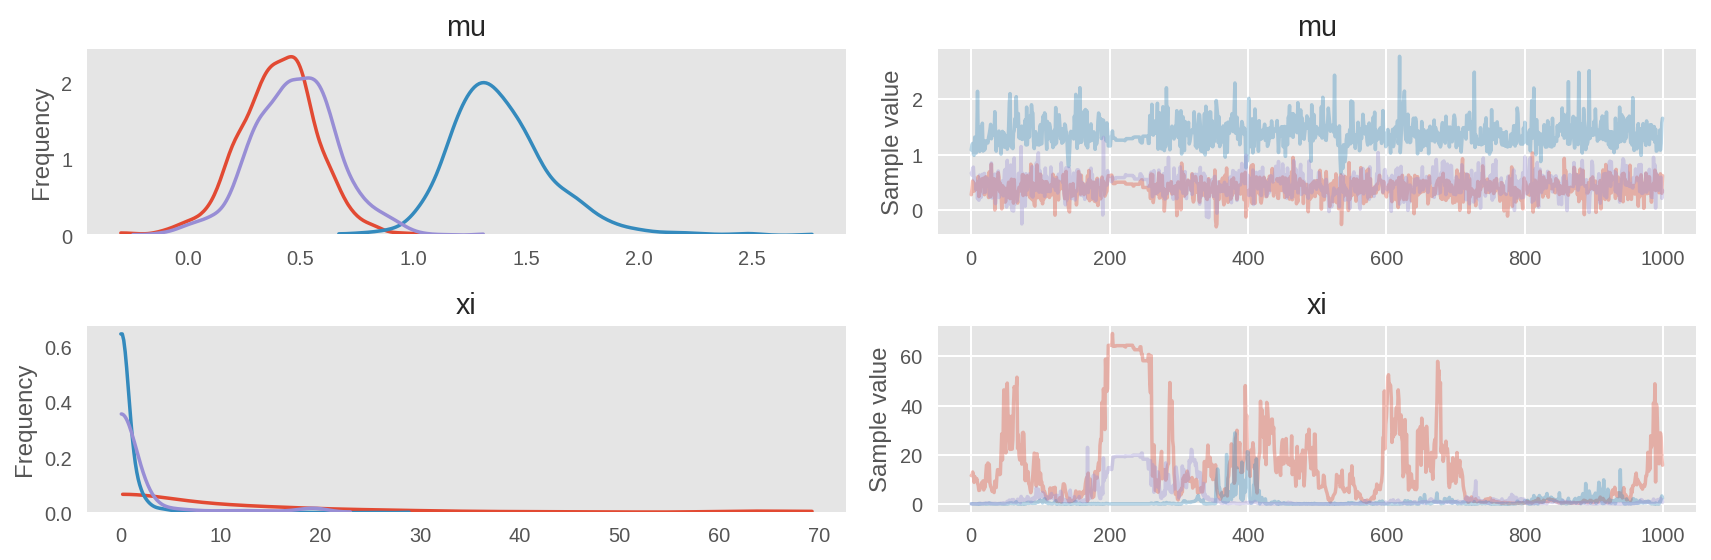

In [25]:
pm.traceplot(trace, varnames=['mu', 'xi']);